# Flight Data Project

### 2 Pax Load Factor Prediction

##### This notebook builds the reproducible machine learning pipeline for predicting the passenger load factor per flight route. The cleaned dataset generated in the previous exploratory and preprocessing phase (see 1_eda_and_cleaning.ipynb) is used as the starting point. The goal is to develop a robust model that can support airlines in optimizing route planning and capacity management.

Import packages

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Read the cleaned data

In [33]:
pax_load_data = pd.read_csv('../data/passenger_load_data.csv')

Define features and target y

In [34]:
# Define target
target = "pax_load_factor"

# Drop target & non-feature columns
X = pax_load_data.drop(columns=[target])
y = pax_load_data[target]

# Identify feature types
num_features = X.select_dtypes(include=["int64", "float64", "Int64", "Float64"]).columns.tolist()
cat_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numerical features:", num_features)
print("Categorical features:", cat_features)

Numerical features: ['departures_performed', 'payload', 'freight', 'mail', 'distance', 'air_time', 'carrier_group', 'aircraft_type', 'aircraft_config']
Categorical features: ['route']


Preprocessing: Imputing, scaling and encoding

Numerical features are imputed (median) and scaled. Categorical features are imputed (most frequent) and one-hot encoded. Even though the current dataset has no missing values, imputers are included to ensure robustness on operational data.

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num",
         Pipeline([("imputer", SimpleImputer(strategy="median")),
                   ("scaler", StandardScaler())]),
         num_features),
        ("cat",
         Pipeline([("imputer", SimpleImputer(strategy="most_frequent")),
                   ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=True))]),
         cat_features),
    ],
    remainder="drop",
)

Split the data into train- and test data

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Check shape of train data

In [37]:
X_train.shape

(288151, 10)

Define models

To evaluate different approaches for predicting the passenger load factor, several regression models are compared.
A simple baseline model (predicting the mean value) is used as a reference to assess the predictive quality of more complex models.

In [38]:
models = {
    "Baseline (Mean)": DummyRegressor(strategy="mean"),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=12, n_jobs=-1,random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(max_depth=3, n_estimators=200, random_state=42)
}

Train, predict and evaluate results

In [39]:
evaluation_results = []

CV = 3

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("model", model)
    ])

# Cross-validation - training on folds
    cv = cross_validate(pipeline, X_train, y_train, cv=CV, scoring={"r2": "r2", "mae": "neg_mean_absolute_error", "rmse": "neg_root_mean_squared_error"}, n_jobs=-1, return_train_score=False)

# Train the model
    pipeline.fit(X_train, y_train)   

# Predict target
    y_pred = pipeline.predict(X_test)

    evaluation_results.append({
        "Model": name,
        "CV_R2_Mean": np.mean(cv["test_r2"]),
        "CV_MAE_Mean": -np.mean(cv["test_mae"]),
        "CV_RMSE_Mean": -np.mean(cv["test_rmse"]),
        "Test_R2": r2_score(y_test, y_pred),
        "Test_MAE": mean_absolute_error(y_test, y_pred),
        "Test_RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    })

# Convert results to DataFrame
results_df = pd.DataFrame(evaluation_results).sort_values("Test_R2", ascending=False)
results_df



,Model,CV_R2_Mean,CV_MAE_Mean,CV_RMSE_Mean,Test_R2,Test_MAE,Test_RMSE
2,Random Forest,0.487954,0.110877,0.149834,0.493021,0.110509,0.149453
3,Gradient Boosting,0.439051,0.117414,0.156826,0.442419,0.117284,0.156734
1,Linear Regression,0.427215,0.113101,0.158472,0.441973,0.111824,0.156797
0,Baseline (Mean),-0.000003,0.160391,0.209390,-0.000018,0.160752,0.209900


In [40]:
# Best Model
best_row = results_df.loc[results_df["Test_R2"].idxmax()]

best_model_name = best_row["Model"]
best_model_r2 = best_row["Test_R2"]
best_model_mae = best_row["Test_MAE"]
best_model_rmse = best_row["Test_RMSE"]

print("Best Performing Model (by R²):")
print(f"Model: {best_model_name}")
print(f"R² on Test Set: {best_model_r2:.3f}")
print(f"MAE on Test Set: {best_model_mae:.3f}")
print(f"RMSE on Test Set: {best_model_rmse:.3f}")

Best Performing Model (by R²):
Model: Random Forest
R² on Test Set: 0.493
MAE on Test Set: 0.111
RMSE on Test Set: 0.149


Error Plots for Best Model

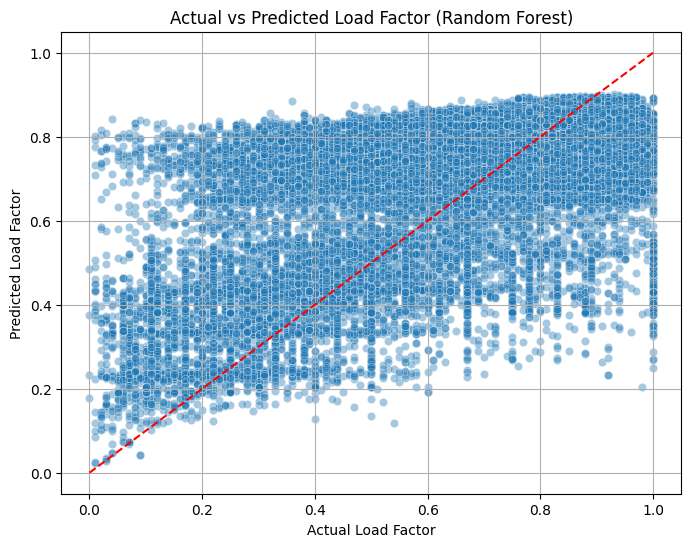

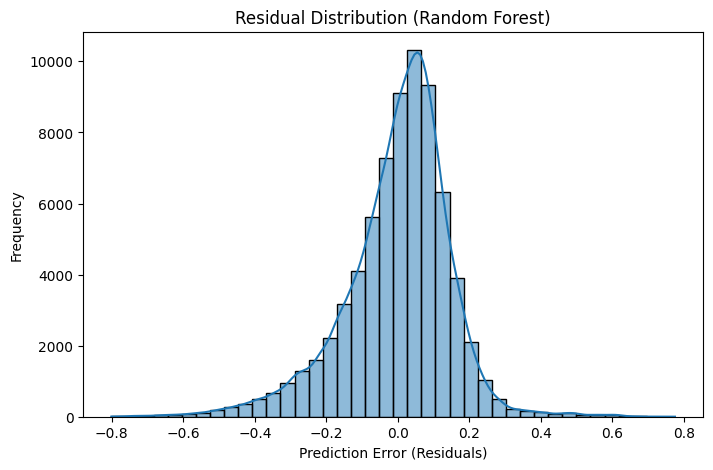

In [45]:
# Retrain best model on full training data and predict on test set
best_model = models[best_model_name]
best_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", best_model)
])
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)

# Plot Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title(f"Actual vs Predicted Load Factor ({best_model_name})")
plt.xlabel("Actual Load Factor")
plt.ylabel("Predicted Load Factor")
plt.grid(True)
plt.show()

# Residuals Plot
residuals = y_test - y_pred
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=40, kde=True)
plt.title(f"Residual Distribution ({best_model_name})")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.show()


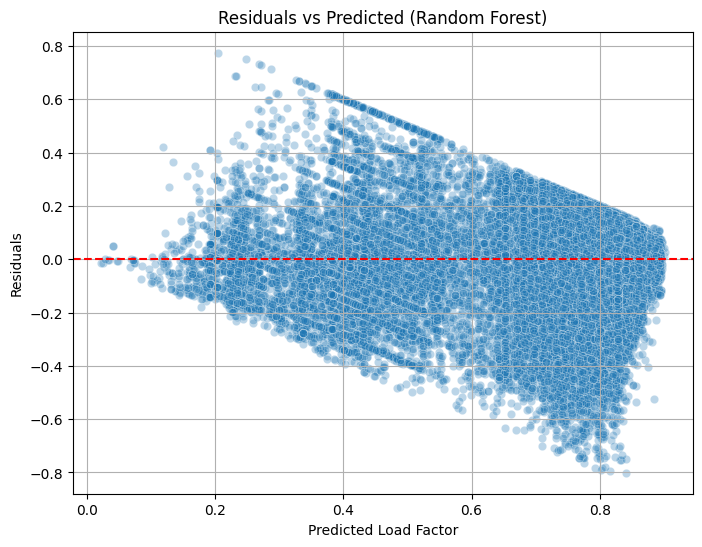

In [ ]:
# Plot Predicted vs Residuals
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title(f"Residuals vs Predicted ({best_model_name})")
plt.xlabel("Predicted Load Factor")
plt.ylabel("Residuals")
plt.grid(True)
plt.show()
